In [3]:
!pip install fastai -Uqq

     |████████████████████████████████| 197 kB 5.4 MB/s 
     |████████████████████████████████| 59 kB 4.4 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/colab_notebooks/algovera/defi/v2

/content/drive/MyDrive/colab_notebooks/algovera/defi/v2


In [203]:
from fastai.tabular.all import *
from tqdm import tqdm
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

SEED=42

import warnings
warnings.filterwarnings('ignore')

In [204]:
df = pd.read_csv('data/aave_V2_mainnet_2021_2022.csv')

# Prepare data

In [205]:
df1 = pd.DataFrame()
for tok in df.symbol.unique():
    df_tok = df[df['symbol']==tok]
    df_tok = df_tok.drop(['symbol'], axis=1)

    col_names = []
    for col in df_tok.columns:
        if col == 'Timestamp':
            col_names.append(f'{col}')
        else:
            col_names.append(f'{tok}_{col}')
        
    df_tok.columns = col_names
    #df_tok = df_tok.set_index('Timestamp', drop=True)
    
    if df1.empty:
        df1 = df_tok
    else:
        df1 = pd.merge(df1, df_tok, on='Timestamp')

In [206]:
selcols =['Timestamp',
          
          'WETH_totalATokenSupply', 'WETH_totalCurrentVariableDebt', 'WETH_utilizationRate',
          'WETH_totalLiquidity', 'WETH_liquidityRate', 'WETH_variableBorrowRate',
          'WETH_availableLiquidity', 

          'USDC_totalATokenSupply', 'USDC_totalCurrentVariableDebt', 'USDC_utilizationRate',
          'USDC_totalLiquidity', 'USDC_liquidityRate', 'USDC_variableBorrowRate',
          'USDC_availableLiquidity', 

          'DAI_totalATokenSupply', 'DAI_totalCurrentVariableDebt', 'DAI_utilizationRate', 
          'DAI_totalLiquidity', 'DAI_liquidityRate', 'DAI_variableBorrowRate', 
          'DAI_availableLiquidity', 

          'USDT_totalATokenSupply', 'USDT_totalCurrentVariableDebt', 'USDT_utilizationRate',
          'USDT_totalLiquidity', 'USDT_liquidityRate', 'USDT_variableBorrowRate',
          'USDT_availableLiquidity', 

          'TUSD_totalATokenSupply','TUSD_totalCurrentVariableDebt', 'TUSD_utilizationRate', 
          'TUSD_totalLiquidity', 'TUSD_liquidityRate', 'TUSD_variableBorrowRate', 
          'TUSD_availableLiquidity', 
          
          'GUSD_totalATokenSupply', 'GUSD_totalCurrentVariableDebt', 'GUSD_utilizationRate',
          'GUSD_totalLiquidity', 'GUSD_liquidityRate', 'GUSD_variableBorrowRate',
          'GUSD_availableLiquidity']

In [207]:
df1 = df1.copy()[selcols]

In [208]:
df1['Datetime'] = pd.to_datetime(df1['Timestamp'], 
                                utc=True, 
                                unit='s')

In [209]:
df1 = df1.resample('D', on='Datetime').mean().reset_index()

In [210]:
df1.head(5)

,Datetime,Timestamp,WETH_totalATokenSupply,WETH_totalCurrentVariableDebt,WETH_utilizationRate,WETH_totalLiquidity,WETH_liquidityRate,WETH_variableBorrowRate,WETH_availableLiquidity,USDC_totalATokenSupply,...,TUSD_liquidityRate,TUSD_variableBorrowRate,TUSD_availableLiquidity,GUSD_totalATokenSupply,GUSD_totalCurrentVariableDebt,GUSD_utilizationRate,GUSD_totalLiquidity,GUSD_liquidityRate,GUSD_variableBorrowRate,GUSD_availableLiquidity
0,2021-01-07 00:00:00+00:00,1.610031e+09,84750.351978,11970.828619,0.143118,84745.324996,0.002326,0.017621,72626.086059,4.057548e+07,...,0.161531,0.784189,761.379118,9.820358e+05,7.875308e+05,0.801610,9.817394e+05,0.072483,0.086730,1.945049e+05
1,2021-01-08 00:00:00+00:00,1.610106e+09,83328.254715,11613.940550,0.141079,83322.700803,0.002256,0.017370,71568.431859,4.227095e+07,...,0.094322,0.393143,70331.339062,1.658645e+06,8.170101e+05,0.652060,1.658095e+06,0.057897,0.073888,8.416302e+05
2,2021-01-09 00:00:00+00:00,1.610193e+09,80783.141028,12833.291240,0.161035,80776.940035,0.002935,0.019827,67776.018095,4.235582e+07,...,0.084344,0.430223,63420.260362,3.483185e+06,1.036266e+06,0.297285,3.482514e+06,0.004429,0.014871,2.446920e+06
3,2021-01-10 00:00:00+00:00,1.610279e+09,81857.790752,15097.569991,0.187985,81850.728479,0.004022,0.023145,66459.021406,4.710354e+07,...,0.115696,0.738090,7905.939785,3.483244e+06,1.438745e+06,0.413167,3.482514e+06,0.008617,0.020665,2.044499e+06
4,2021-01-11 00:00:00+00:00,1.610365e+09,77718.597127,15009.857370,0.198467,77710.418299,0.004517,0.024437,62298.542903,4.499326e+07,...,0.176381,0.482116,46327.036995,3.471151e+06,1.520788e+06,0.437981,3.470261e+06,0.009605,0.021906,1.950364e+06


In [211]:
df1.columns

Index(['Datetime', 'Timestamp', 'WETH_totalATokenSupply',
       'WETH_totalCurrentVariableDebt', 'WETH_utilizationRate',
       'WETH_totalLiquidity', 'WETH_liquidityRate', 'WETH_variableBorrowRate',
       'WETH_availableLiquidity', 'USDC_totalATokenSupply',
       'USDC_totalCurrentVariableDebt', 'USDC_utilizationRate',
       'USDC_totalLiquidity', 'USDC_liquidityRate', 'USDC_variableBorrowRate',
       'USDC_availableLiquidity', 'DAI_totalATokenSupply',
       'DAI_totalCurrentVariableDebt', 'DAI_utilizationRate',
       'DAI_totalLiquidity', 'DAI_liquidityRate', 'DAI_variableBorrowRate',
       'DAI_availableLiquidity', 'USDT_totalATokenSupply',
       'USDT_totalCurrentVariableDebt', 'USDT_utilizationRate',
       'USDT_totalLiquidity', 'USDT_liquidityRate', 'USDT_variableBorrowRate',
       'USDT_availableLiquidity', 'TUSD_totalATokenSupply',
       'TUSD_totalCurrentVariableDebt', 'TUSD_utilizationRate',
       'TUSD_totalLiquidity', 'TUSD_liquidityRate', 'TUSD_variableBorrowR

In [212]:
df_train = df1[df1['Datetime'] <= '2021-12-31']

# Utility functions

In [213]:
def get_tabpandas_multi(
    df:pd.DataFrame, # Dataframe of the raw data 
    n_timepoint:int, # Number of previous timepoints to be used as features   
    target_window:int, # Number of timepoints in the future to predict 
    inference:bool=False, # Flag True for inference
):

    df = df.reset_index(drop=True)
    feature_cols = [
          'WETH_totalATokenSupply', 'WETH_totalCurrentVariableDebt', 'WETH_utilizationRate',
          'WETH_totalLiquidity', 'WETH_liquidityRate', 'WETH_variableBorrowRate',
          'WETH_availableLiquidity', 

          'USDC_totalATokenSupply', 'USDC_totalCurrentVariableDebt', 'USDC_utilizationRate',
          'USDC_totalLiquidity', 'USDC_liquidityRate', 'USDC_variableBorrowRate',
          'USDC_availableLiquidity', 

          'DAI_totalATokenSupply', 'DAI_totalCurrentVariableDebt', 'DAI_utilizationRate', 
          'DAI_totalLiquidity', 'DAI_liquidityRate', 'DAI_variableBorrowRate', 
          'DAI_availableLiquidity', 

          'USDT_totalATokenSupply', 'USDT_totalCurrentVariableDebt', 'USDT_utilizationRate',
          'USDT_totalLiquidity', 'USDT_liquidityRate', 'USDT_variableBorrowRate',
          'USDT_availableLiquidity', 

          'TUSD_totalATokenSupply','TUSD_totalCurrentVariableDebt', 'TUSD_utilizationRate', 
          'TUSD_totalLiquidity', 'TUSD_liquidityRate', 'TUSD_variableBorrowRate', 
          'TUSD_availableLiquidity', 
          
          'GUSD_totalATokenSupply', 'GUSD_totalCurrentVariableDebt', 'GUSD_utilizationRate',
          'GUSD_totalLiquidity', 'GUSD_liquidityRate', 'GUSD_variableBorrowRate',
          'GUSD_availableLiquidity'
          ]

    target_columns = ['USDC_variableBorrowRate', 'DAI_variableBorrowRate', 'USDT_variableBorrowRate',
                      'TUSD_variableBorrowRate', 'GUSD_variableBorrowRate']
    target = 'Target'

    cols_names = []
    for j in range(n_timepoint):
        for col in feature_cols:
            cols_names.append(f'{col}_t-{n_timepoint -j-1}')
    cols_names += [target]

    pairs = []
    for i, row in tqdm(df.iterrows()):
        if i < (len(df)-target_window-n_timepoint-1):
            features = df.loc[i:i+n_timepoint-1, feature_cols].values
            features = [item for sublist in features for item in sublist]

            val =  df.loc[i+n_timepoint: i+n_timepoint-1+target_window, target_columns].mean().idxmin()

            features += [val]
            pairs.append(features)

    df = pd.DataFrame(pairs, columns=cols_names).dropna().reset_index(drop=True)
    
    if not inference:
        x = df.iloc[:, :-1]
        y = df.iloc[:, -1]

        x_train, x_test, y_train, y_test = train_test_split(x, 
                                                            y, 
                                                            test_size=0.2, 
                                                            random_state=SEED)

        ss = StandardScaler()
        x_train = ss.fit_transform(x_train)
        x_test = ss.transform(x_test)

        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_test = le.transform(y_test)

        return df, x_train, x_test, y_train, y_test, ss, le 

    if inference:
        return df


def plot_confusion_matrix(
    preds,
    targs,
    le,
):
    cm = confusion_matrix(targs, 
                          preds, 
                          normalize=None)
    
    df_cm = pd.DataFrame(cm, 
                         columns=le.classes_, 
                         index=le.classes_)
    
    sns.heatmap(df_cm, 
                annot=True, 
                annot_kws={"size": 16},
                cmap="Blues")
    
    plt.show()

    print(f"accuracy score: {accuracy_score(targs, preds)}")

def save_models(
    ntp,
    tw,
    ss,
    le,
    clf
):

    save_pickle(f'models/ss_rfc_{ntp}_{tw}.pkl', ss)
    save_pickle(f'models/le_rfc_{ntp}_{tw}.pkl', le)
    save_pickle(f'models/rfc_{ntp}_{tw}.pkl', clf)

def load_models(
    ntp,
    tw,  
):
    ss = load_pickle(f'models/ss_rfc_{ntp}_{tw}.pkl')
    le = load_pickle(f'models/le_rfc_{ntp}_{tw}.pkl')
    clf = load_pickle(f'models/rfc_{ntp}_{tw}.pkl')

    return ss, le, clf

# n_timepoints = 5, Target_window = 7




359it [00:00, 529.37it/s]


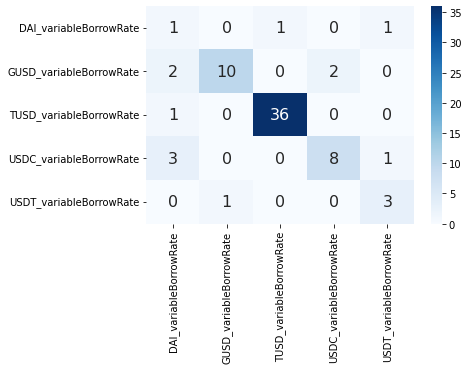

accuracy score: 0.8285714285714286


In [214]:
ntp = 5
tw = 7

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
df['Target'].value_counts()

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf)

# n_timepoints = 5, Target_window = 14


359it [00:00, 520.69it/s]


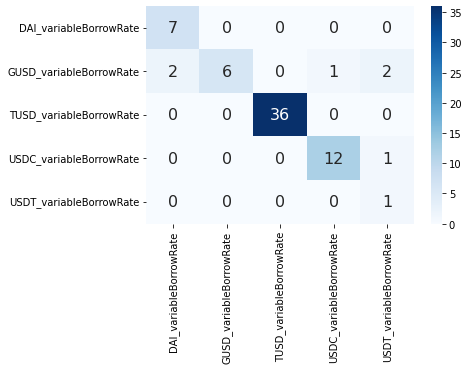

accuracy score: 0.9117647058823529


In [215]:
ntp = 5
tw = 14

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
df['Target'].value_counts()

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf)

# n_timepoints = 5, Target_window = 21

359it [00:01, 248.59it/s]


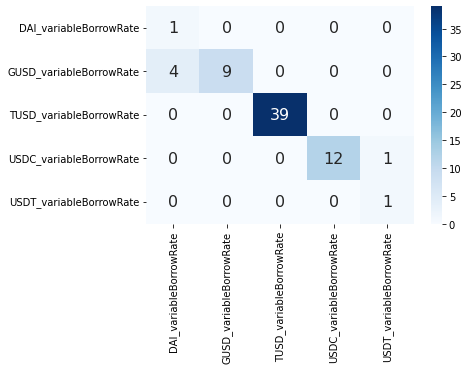

accuracy score: 0.9253731343283582


In [216]:
ntp = 5
tw = 21

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
df['Target'].value_counts()

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf)

# n_timepoints = 5, Target_window = 28




359it [00:01, 245.34it/s]


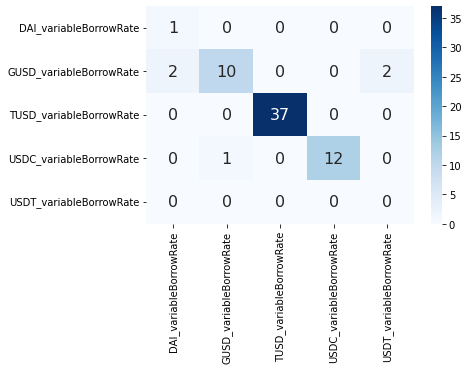

accuracy score: 0.9230769230769231


In [217]:
ntp = 5
tw = 28

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
df['Target'].value_counts()

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf)

# n_timepoints = 5, Target_window = 56


359it [00:01, 214.01it/s]


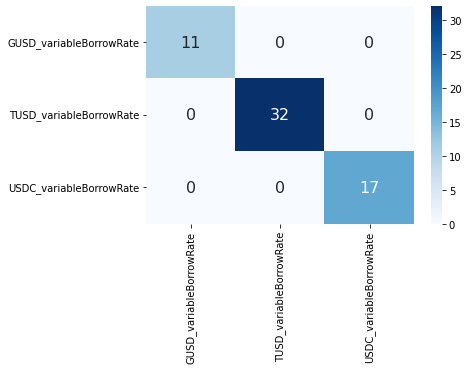

accuracy score: 1.0


In [218]:
ntp = 5
tw = 56

df, x_train, x_test, y_train, y_test, ss, le = get_tabpandas_multi(df_train, ntp, tw)
df['Target'].value_counts()

clf = RandomForestClassifier(n_estimators=90, random_state=SEED)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)
plot_confusion_matrix(y_test, preds, le)
save_models(ntp, tw, ss, le, clf)

# Comparing Strategies 

In [222]:
df_test = df1[df1['Datetime'] > '2021-12-31'].reset_index(drop=True)
df_test = df_test.iloc[:, 2:]

In [231]:
ntp=5
tw=7
def strategy_cost(row):
    return row[row.Predict] * row['Borrow Amount']/365

def compare_strategy(ntp, tw, initial_borrow):

    ss, le, clf = load_models(ntp, tw)

    chunks = []
    for i, v in enumerate(range(0, len(df_test), tw)):
        if i == 0:
            chunks.append(df_test.loc[:ntp+tw-1].copy().reset_index(drop=True))
        else:
            chunks.append(df_test.loc[v:v+ntp+tw-1].copy().reset_index(drop=True))

    for i, chu in enumerate(chunks):
        if len(chu) == ntp+tw:
            x = np.array(chu.iloc[:ntp, :].values.reshape(1, -1))
            x = ss.transform(x)
            pred = clf.predict(x)
            pred = le.classes_[pred]

            chu.loc[ntp:, 'Predict'] = pred[0]  
            if i == 0:
                final = chu.dropna()
            else:
                final = final.append(chu.dropna()).reset_index(drop=True)

    final['Borrow Amount'] = initial_borrow

    final['DAI_br_cost'] = final['DAI_variableBorrowRate'] * final['Borrow Amount']/365
    final['USDC_br_cost'] = final['USDC_variableBorrowRate'] * final['Borrow Amount']/365
    final['USDT_br_cost'] = final['USDT_variableBorrowRate'] * final['Borrow Amount']/365
    final['TUSD_br_cost'] = final['TUSD_variableBorrowRate'] * final['Borrow Amount']/365
    final['GUSD_br_cost'] = final['GUSD_variableBorrowRate'] * final['Borrow Amount']/365

    final['Strategy_br_cost'] = final.apply(lambda row: strategy_cost(row), axis=1)

    return final

In [232]:
final_7 = compare_strategy(5, 7, 1000000)

In [236]:
final_7.iloc[:, -6:].sum()

DAI_br_cost         11216.470362
USDC_br_cost        10516.176711
USDT_br_cost        11827.596843
TUSD_br_cost         9714.342964
GUSD_br_cost         9720.744761
Strategy_br_cost     9714.342964
dtype: float64

In [238]:
final_14 = compare_strategy(5, 14, 1000000)

In [239]:
final_14.iloc[:, -6:].sum()

DAI_br_cost         10545.415492
USDC_br_cost         9930.482467
USDT_br_cost        11245.050321
TUSD_br_cost         9106.463479
GUSD_br_cost         9148.700913
Strategy_br_cost     9106.463479
dtype: float64

In [240]:
final_21 = compare_strategy(5, 21, 1000000)

In [241]:
final_21.iloc[:, -6:].sum()

DAI_br_cost          9873.735243
USDC_br_cost         9284.063234
USDT_br_cost        10617.397300
TUSD_br_cost         8488.263495
GUSD_br_cost         8585.531410
Strategy_br_cost     8488.263495
dtype: float64

In [242]:
final_28 = compare_strategy(5, 28, 1000000)

In [243]:
final_28.iloc[:, -6:].sum()

DAI_br_cost         10545.415492
USDC_br_cost         9930.482467
USDT_br_cost        11245.050321
TUSD_br_cost         9106.463479
GUSD_br_cost         9148.700913
Strategy_br_cost     9106.463479
dtype: float64